# Controlnet lineart anime

ControlNet　Lineart animeは、拡散モデルの建物、壁紙、人の肌など表層的な質感やテクスチャを変更することができる手法です．

- ドキュメント:https://huggingface.co/lllyasviel/sd-controlnet-canny

<a href="https://colab.research.google.com/github/fuyu-quant/data-science-wiki/blob/main/multimodal/text_to_image/latent_consistency_models.ipynb" target="_blank" rel="noopener noreferrer"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install diffusers==0.23.0
!pip install accelerate==0.24.1
!pip install transformers==4.35.0
!pip install opencv-contrib-python==4.8.0.76
!pip3 install -U xformers --index-url https://download.pytorch.org/whl/cu118
!pip install controlnet_aux==0.0.3
#!pip install torch==2.1.0+cu118

In [2]:
import torch
print(torch.version.cuda)
# 実行が確認できたcudaのバージョン
# 11.8

11.8


In [3]:
import torch
import os
from huggingface_hub import HfApi
from pathlib import Path
from diffusers.utils import load_image
from PIL import Image
import numpy as np
from controlnet_aux import LineartAnimeDetector
from transformers import CLIPTextModel
import requests
import IPython.display as display

from diffusers import ControlNetModel, StableDiffusionControlNetPipeline, UniPCMultistepScheduler

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

### 画像の用意

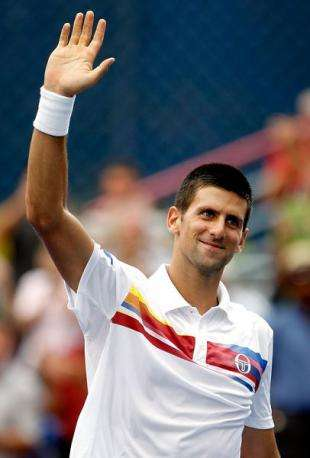

In [4]:
image = load_image("https://huggingface.co/lllyasviel/control_v11p_sd15_openpose/resolve/main/images/input.png")
image

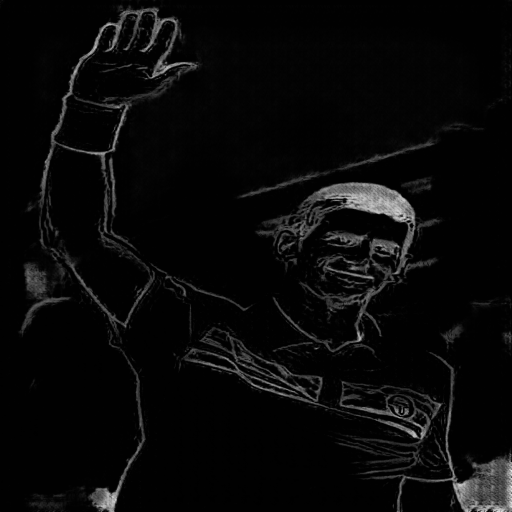

In [5]:
image = image.resize((512, 512))

processor = LineartAnimeDetector.from_pretrained("lllyasviel/Annotators")

control_image = processor(image)
control_image.save("control.png")
control_image

### Stable Diffusionのダウンロード

In [6]:
text_encoder = CLIPTextModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="text_encoder", num_hidden_layers=11, torch_dtype=torch.float16)
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15s2_lineart_anime", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", text_encoder=text_encoder, controlnet=controlnet, torch_dtype=torch.float16)

Some weights of the model checkpoint at runwayml/stable-diffusion-v1-5 were not used when initializing CLIPTextModel: ['text_model.encoder.layers.11.self_attn.v_proj.bias', 'text_model.encoder.layers.11.self_attn.out_proj.bias', 'text_model.encoder.layers.11.layer_norm2.bias', 'text_model.encoder.layers.11.self_attn.q_proj.bias', 'text_model.encoder.layers.11.self_attn.k_proj.weight', 'text_model.encoder.layers.11.mlp.fc1.bias', 'text_model.encoder.layers.11.self_attn.k_proj.bias', 'text_model.encoder.layers.11.self_attn.out_proj.weight', 'text_model.encoder.layers.11.layer_norm1.bias', 'text_model.encoder.layers.11.self_attn.q_proj.weight', 'text_model.encoder.layers.11.layer_norm2.weight', 'text_model.encoder.layers.11.mlp.fc2.bias', 'text_model.encoder.layers.11.mlp.fc2.weight', 'text_model.encoder.layers.11.layer_norm1.weight', 'text_model.encoder.layers.11.mlp.fc1.weight', 'text_model.encoder.layers.11.self_attn.v_proj.weight']
- This IS expected if you are initializing CLIPTextMo

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [7]:
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
generator = torch.manual_seed(0)

  0%|          | 0/30 [00:00<?, ?it/s]

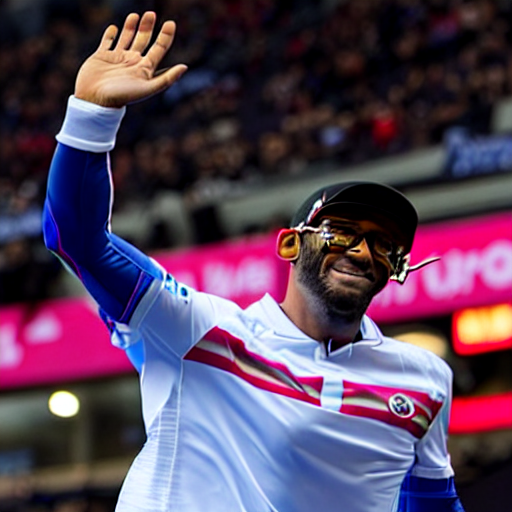

In [8]:
prompt = ""
nagative_prompt = "paintings, sketches,(worst quality:2),(low quality:2),(normal quality:2)"
image = pipe(prompt, negative_prompt = nagative_prompt, num_inference_steps=30, generator=generator, image=control_image).images[0]
display.display(image)

In [ ]:
image.save('image_out.png')